In [1]:
import matplotlib.pyplot as plt
# import deeptrack as dt
import numpy as np

float64


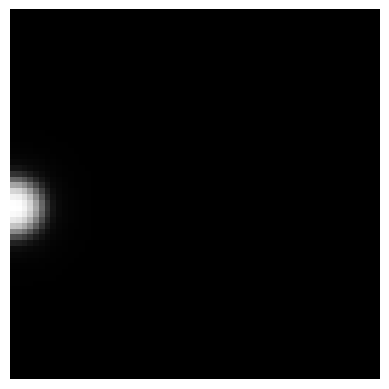

(18000, 1, 64, 64)
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
t

In [2]:
from torch.utils.data import DataLoader
import torch


data = np.load("dataset.npz")
images = data["images"]
print(images.dtype)  
plt.imshow(images[0][0].squeeze(), cmap='gray')  
plt.axis('off')
plt.show()
images= images.reshape(-1,1,64,64)
print(images.shape)
# Define the CustomDataset class
class CustomDataset():
    def __init__(self, images):
        self.images = images



    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self.images[idx]
        # Convert NumPy array to PyTorch tensor and then to float
        x = torch.tensor(x).float()
       
        return x, x  # Return the input and output tensors (both are the same)
# normalize = transforms.Normalize(mean=[0.5], std=[0.5])

# Create an instance of the custom dataset class
custom_dataset = CustomDataset(images)

# Create a DataLoader
loader = DataLoader(custom_dataset, batch_size=8, shuffle=True)  # Corrected line

from torch.utils.data import random_split

# Define the size of the training and testing sets
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# Create DataLoader instances for the training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle the test set

for data in train_loader:
    print(data[0].shape)

In [3]:
import numpy as np
import torch
import torch.nn as nn

# Step 1: Divide Image into Patches
def split_image_into_patches(image, patch_size):
    patches = []
    height, width = image.shape
    for h in range(0, height, patch_size):
        for w in range(0, width, patch_size):
            patch = image[h:h+patch_size, w:w+patch_size]
            patches.append(patch)
    return patches

# Step 2: Reshape Patches
def reshape_patches_to_vectors(patches):
    return [patch.flatten() for patch in patches]

# Step 3: Embed Patches
class PatchEmbedding(nn.Module):
    def __init__(self, input_dim, embed_dim, patch_size, image_size):
        super(PatchEmbedding, self).__init__()
        self.patch_embedding = nn.Linear(input_dim, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))  # Learnable CLS token
        # print(f'tokenshpe {self.cls_token.shape}')
        self.positional_embedding = nn.Parameter(torch.randn((image_size // patch_size) ** 2, 1, embed_dim))  # Positional embeddings for patches
        # print(f'positioanl {self.positional_embedding.shape}')

    def forward(self, x):
        batch_size, num_patches, _ = x.size()  # Get the batch size and number of patches directly from the tensor
        print(x.size())
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        print(f'after self embedding{x.shape}')
        x = x + self.positional_embedding  # Adding positional embeddings
        print(f'after adding positional {x.shape}')
        x = torch.cat((cls_tokens, x), dim=1)  # Concatenating CLS tokens
        print(f'after CLS {x.shape}')
        return x

# Example Usage
image = images[0][0]  # Example 64x64 image
print(f'input{image.shape}')
patches = split_image_into_patches(image, patch_size=8)
patch_vectors = reshape_patches_to_vectors(patches)

input_dim = 64  # 8x8 patch size
embed_dim = 256  # Dimensionality of the embedding space
patch_size = 8  # Size of each patch
image_size = 64  # Size of the image
embedding_layer = PatchEmbedding(input_dim=input_dim, embed_dim=embed_dim, patch_size=patch_size, image_size=image_size)

# Convert patches to tensor and unsqueeze to add batch dimension
patch_tensors = [torch.Tensor(patch).unsqueeze(0) for patch in patch_vectors]

# Stack the patches along the batch dimension
batched_patches = torch.stack(patch_tensors, dim=0)
print(batched_patches.shape)
embedded_patches = embedding_layer(batched_patches)
print(embedded_patches.shape)  # Output shape of the embedded patches


input(64, 64)
torch.Size([64, 1, 64])
torch.Size([64, 1, 64])
after self embeddingtorch.Size([64, 1, 256])
after adding positional torch.Size([64, 1, 256])
after CLS torch.Size([64, 2, 256])
torch.Size([64, 2, 256])


In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Step 1: Divide Image into Patches
def split_image_into_patches(image, patch_size):
    patches = []
    height, width = image.shape[-2:]
    for h in range(0, height, patch_size):
        for w in range(0, width, patch_size):
            patch = image[..., h:h+patch_size, w:w+patch_size]
            patches.append(patch)
    return patches

# Step 2: Reshape Patches
def reshape_patches_to_vectors(patches):
    return [patch.flatten(start_dim=1) for patch in patches]

# Step 3: Embed Patches
class PatchEmbedding(nn.Module):
    def __init__(self, input_dim, embed_dim, patch_size, image_size):
        super(PatchEmbedding, self).__init__()
        self.patch_embedding = nn.Linear(input_dim, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))  # Learnable CLS token
        self.positional_embedding = nn.Parameter(torch.randn((image_size // patch_size) ** 2, 1, embed_dim))  # Positional embeddings for patches

    def forward(self, x):
        batch_size, num_channels, height, width = x.size()
        x = x.view(batch_size, num_channels, height * width)  # Flattening the spatial dimensions
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = x + self.positional_embedding  # Adding positional embeddings
        x = torch.cat((cls_tokens, x), dim=1)  # Concatenating CLS tokens
        return x

# Example Usage with DataLoader
batch_size = 32
input_dim = 64  # 8x8 patch size
embed_dim = 256  # Dimensionality of the embedding space
patch_size = 8  # Size of each patch
image_size = 64  # Size of the image

# Creating dummy DataLoader
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create PatchEmbedding instance
embedding_layer = PatchEmbedding(input_dim=input_dim, embed_dim=embed_dim, patch_size=patch_size, image_size=image_size)

for batch in train_loader:
    inputs, out = batch
    embedded_patches = embedding_layer(inputs)
    print("Input shape:", inputs.shape)
    print("Embedded patches shape:", embedded_patches.shape)
    break  # Only print the first batch


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4096 and 64x256)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SingleAttention(nn.Module):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.query = nn.Linear(d_k, d_k)
        self.key = nn.Linear(d_k, d_k)
        self.value = nn.Linear(d_v, d_v)
        # self.sqrt_dk = torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    def forward(self, q, k, v):
            q = self.query(q)
            k = self.key(k)
            v = self.value(v)
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1))
            weights = F.softmax(scores, dim=-1)
            output = torch.matmul(weights, v)
            return output, weights

# class MultiHeadAttention(nn.Module):
#     def __init__(self, num_heads, d_k, d_v, d_model=128):
#         super(MultiHeadAttention, self).__init__()
#         # Make sure the output dimensions collectively match d_model
#         # self.heads = nn.ModuleList([SingleAttention(d_k // num_heads, d_v // num_heads) for _ in range(num_heads)])
#         # self.linear = nn.Linear(d_v, d_model)  # This should align with the expected size
#         self.heads = nn.ModuleList([SingleAttention(d_k, d_v) for _ in range(num_heads)])
#         self.linear = nn.Linear(num_heads * d_v, d_k)

#     def forward(self, q, k, v):
#         outputs, weights = zip(*(head(q, k, v) for head in self.heads))
#         concat_output = torch.cat(outputs, dim=-1)
#         output = self.linear(concat_output)  # Align dimensions
#         return output, torch.stack(weights, dim=0)
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, d_k, d_v, d_model=128):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_k = d_k
        self.d_v = d_v
        self.d_model = d_model

        # Create head modules
        self.heads = nn.ModuleList([SingleAttention(d_k, d_v) for _ in range(num_heads)])
        # Final linear layer to adjust the concatenated outputs back to d_model dimensions
        self.linear = nn.Linear(num_heads * d_v, d_model)

    def forward(self, q, k, v):
        # Apply each head's attention to the inputs
        outputs, weights = zip(*(head(q, k, v) for head in self.heads))
        # Concatenate all head outputs along the last dimension
        concat_output = torch.cat(outputs, dim=-1)
        # Pass through the final linear transformation
        output = self.linear(concat_output)
        # Stack weights for visualization or analysis purposes
        weights = torch.stack(weights, dim=0)
        return output, weights


# class TransformerEncoder(nn.Module):
#     def __init__(self, num_heads, d_k, d_v, dense_dim, dropout_rate=0.1):
#         super(TransformerEncoder, self).__init__()
#         self.multi_head_attention = MultiHeadAttention(num_heads, d_k, d_v)
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.norm1 = nn.LayerNorm(d_k)

#         self.dense = nn.Sequential(
#             nn.Linear(d_k, dense_dim),
#             nn.ReLU(),
#             nn.Linear(dense_dim, d_k)
#         )
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.norm2 = nn.LayerNorm(d_k)

#     def forward(self, x):
#         # Multi-head attention
#         attn_output,attn_weights  = self.multi_head_attention(x, x, x)
#         x = x + self.dropout1(attn_output)
#         x = self.norm1(x)

#         # Feedforward network
#         dense_output = self.dense(x)
#         x = x + self.dropout2(dense_output)
#         x = self.norm2(x)
#         return x, attn_weights
class TransformerEncoder(nn.Module):
    def __init__(self, num_heads, d_k, d_v, dense_dim, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads, d_k, d_v)
        self.norm1 = nn.LayerNorm(d_k)
        self.dense = nn.Sequential(
            nn.Linear(d_k, dense_dim),
            nn.ReLU(),
            nn.Linear(dense_dim, d_k),
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.norm2 = nn.LayerNorm(d_k)

    def forward(self, x):
        # Multi-head attention part
        attn_output, attn_weights = self.multi_head_attention(x, x, x)  # Ensure this matches your multi-head implementation
        # print(f'attention weight {attn_weights.shape}')
        x = self.norm1(x + self.dropout(attn_output))

        # Feedforward part
        ff_output = self.dense(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x, attn_weights  



In [38]:
import torch
import torch.nn as nn

class ViTFeatureExtractor(nn.Module):
    def __init__(self, image_size=64, patch_size=4, embed_dim=128, num_heads=8, depth=1, mlp_dim=256, channels=1, dropout_rate=0.1):
        super(ViTFeatureExtractor, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        
        # Number of patches is calculated as image_area / patch_area
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."

        self.num_patches = (image_size // patch_size) ** 2

        # Embedding layer that maps from the flattened patch size to embed_dim
        self.patch_to_embedding = nn.Linear(patch_size * patch_size * channels, embed_dim)

        # Class token initialized as a learnable parameter
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embeddings
        self.position_embeddings = nn.Parameter(torch.zeros(1, 1 + self.num_patches, embed_dim))
        self.transformer_encoders = nn.Sequential(
            *[TransformerEncoder(num_heads, embed_dim, embed_dim, mlp_dim, dropout_rate) for _ in range(depth)]
        )
        self.to_cls_token = nn.Identity()

    def forward(self, x):
        # Create patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size) # to convert image to patch
        # print(f'after unfolding {x.shape}')
        x = x.contiguous().view(x.size(0), -1, self.patch_size * self.patch_size * self.channels)  # Flatten patches
        # print(f'after contiguou {x.shape}')
        # Map patches to embeddings
        x = self.patch_to_embedding(x)
        # print(f'after embedding {x.shape}')
        # Prepend the class token
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        # print(f'cls token{ cls_tokens.shape}' )
        x = torch.cat((cls_tokens, x), dim=1)
        # print(f'cat cls token+x {x.shape}')
        # Add positional embeddings
        x = x + self.position_embeddings
        # print(f'positional embedding{x.shape}')
        # print(self.transformer_encoders(x))
        x, attn_weights  = self.transformer_encoders(x)
        # print(f'after transformer{x.shape}')
        # print(f'attention weight {attn_weights.shape}')

        cls_token = self.to_cls_token(x[:, 0])
        # print(f'cls token= {cls_token.shape}')
        return cls_token, attn_weights




1. **Before `.contiguous()` and `.view()`**:
   - `x` might be non-contiguous due to previous operations.
   - `x.shape` could be `[batch_size, num_patches, 3, 4, 4]`.

2. **Applying `.contiguous()`**:
   - Ensures that the data in `x` is laid out continuously in memory.

3. **Applying `.view()`**:
   - `x.view(batch_size, -1, 4*4*3)` reshapes `x` to `[batch_size, num_patches, 48]`.
   - Here, `48` comes from `4 (height) * 4 (width) * 3 (channels)`, flattening each patch into a vector.


In [30]:
from torch.utils.data import DataLoader

# Assuming train_loader is already defined
vit_features = ViTFeatureExtractor(channels=1)  # Initialize with channels=1 for grayscale images

for batch_idx, (images, _) in enumerate(train_loader):
    print(images.shape)
    output,attn_weights = vit_features(images)
    print(f"Batch {batch_idx}: Output shape {output.shape},{attn_weights.shape}")
    break
print(attn_weights.shape)
    # Optionally process the output here (e.g., pass it to the rest of the Transformer model)


torch.Size([32, 1, 64, 64])
attention weight torch.Size([8, 32, 257, 257])
Batch 0: Output shape torch.Size([32, 128]),torch.Size([8, 32, 257, 257])
torch.Size([8, 32, 257, 257])


In [31]:
from torch.utils.data import DataLoader

# Assuming train_loader is already defined
model = ViTAutoencoder()  # Initialize with channels=1 for grayscale images

for batch_idx, (images, _) in enumerate(train_loader):
    print(images.shape)
    output,attn_weights = model(images)
    print(f"Batch {batch_idx}: Output shape {output.shape},{attn_weights.shape}")
    break
print(attn_weights.shape)
    # Optionally process the output here (e.g., pass it to the rest of the Transformer model)


torch.Size([32, 1, 64, 64])
attention weight torch.Size([8, 32, 257, 257])
Batch 0: Output shape torch.Size([32, 1, 64, 64]),torch.Size([8, 32, 257, 257])
torch.Size([8, 32, 257, 257])


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ViTAutoencoder(nn.Module):
    def __init__(self, image_size=64, patch_size=4, embed_dim=128, num_heads=8, depth=1, mlp_dim=256, channels=1, dropout_rate=0.1, bottleneck_dim=16):
        super(ViTAutoencoder, self).__init__()
        # Initialize the Vision Transformer with the given parameters.
        self.encoder = ViTFeatureExtractor(
            image_size=image_size, 
            patch_size=patch_size, 
            embed_dim=embed_dim, 
            num_heads=num_heads, 
            depth=depth, 
            mlp_dim=mlp_dim, 
            channels=channels, 
            dropout_rate=dropout_rate
        )

        # Bottleneck layer to map the class token to the latent space
        self.bottleneck = nn.Linear(embed_dim, bottleneck_dim)

        # Decoder remains the same as in the original Autoencoder class.
        # You need to adapt the first Linear layer of the decoder to match the bottleneck_dim.
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128*4*4), # Match the bottleneck_dim
            nn.LeakyReLU(0.1),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        class_token,attn_weights = self.encoder(x)
        bottleneck = self.bottleneck(class_token)
        decoded = self.decoder(bottleneck)
        return decoded,attn_weights


Patch embeddings + Positional encoding: [num_patches + 1, embed_dim]
Q, K, V generation:                     [num_patches + 1, embed_dim] each
Attention scores (before softmax):      [num_patches + 1, num_patches + 1]
Attention weights (after softmax):      [num_patches + 1, num_patches + 1]
Weighted sum (Attention output):        [num_patches + 1, embed_dim]


[Input Embeddings]
        |
        V
[Linear Transformations]
(Q, K, V generation)
        |
        V
[Dot Product Q and K]
        |
        V
[Scale by sqrt(dim)]
        |
        V
[Softmax to get Attention Weights] 
        |
        V
[Multiply with V, Sum]
        |
        V
[Concatenate outputs from all heads]
        |
        V
[Linear Transformation]
        |
        V
[Output to next layer/feed-forward network]


Using device: cuda
Epoch:1, Loss:19.7803


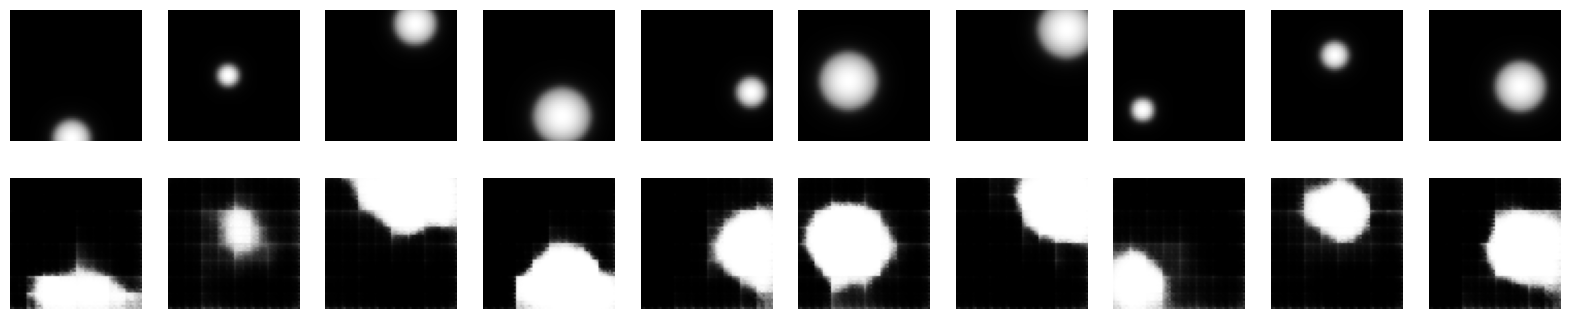

Attention after avg: torch.Size([257, 257])


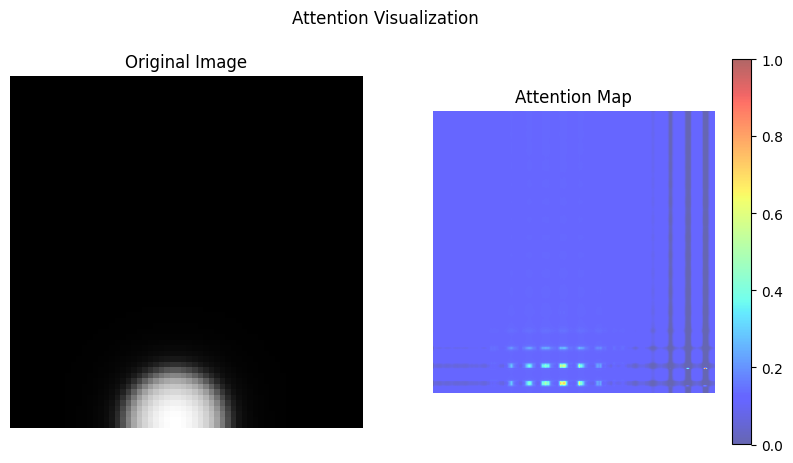

Epoch:2, Loss:19.3051
Epoch:3, Loss:19.2850
Epoch:4, Loss:19.2811
Epoch:5, Loss:19.2800


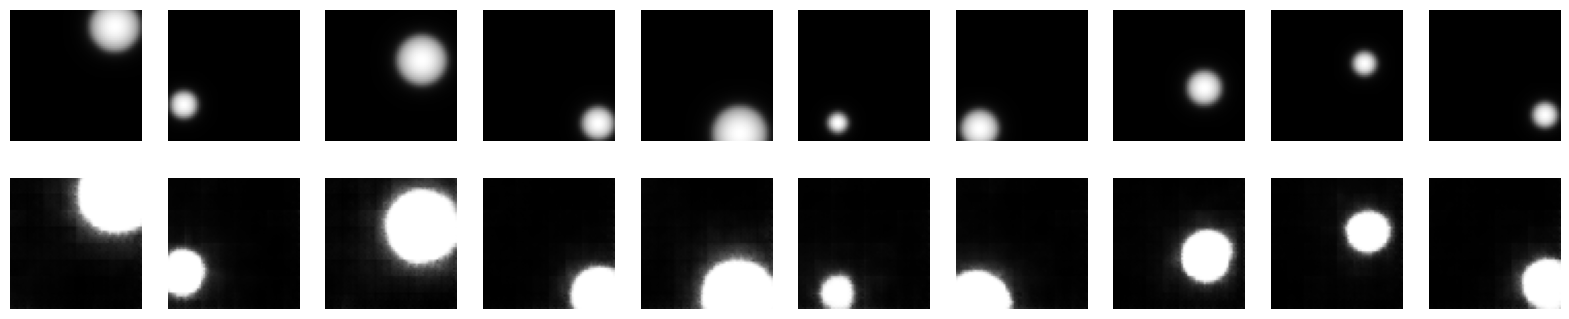

Attention after avg: torch.Size([257, 257])


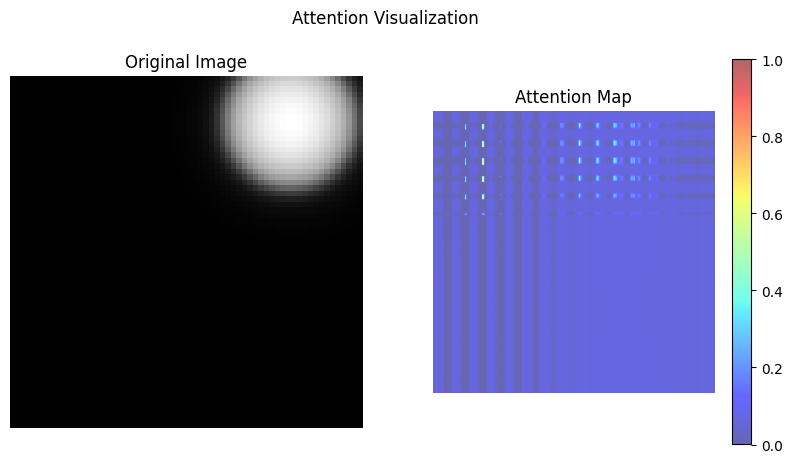

Epoch:6, Loss:19.2754
Epoch:7, Loss:19.2763
Epoch:8, Loss:19.2753
Epoch:9, Loss:19.2745
Epoch:10, Loss:19.2731


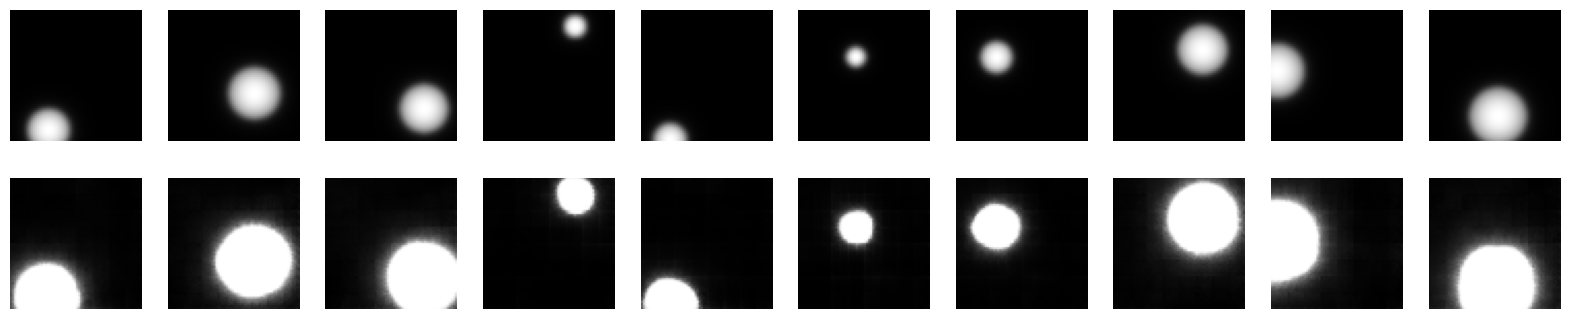

Attention after avg: torch.Size([257, 257])


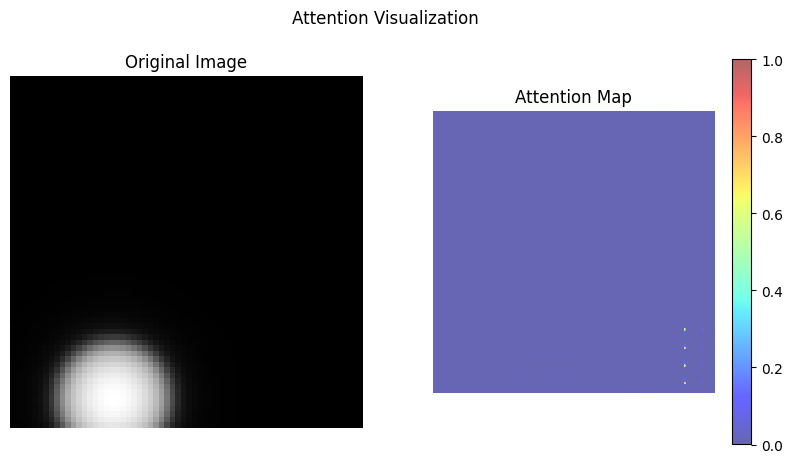

Epoch:11, Loss:19.2704
Epoch:12, Loss:19.2703
Epoch:13, Loss:19.2705
Epoch:14, Loss:19.2707
Epoch:15, Loss:19.2707


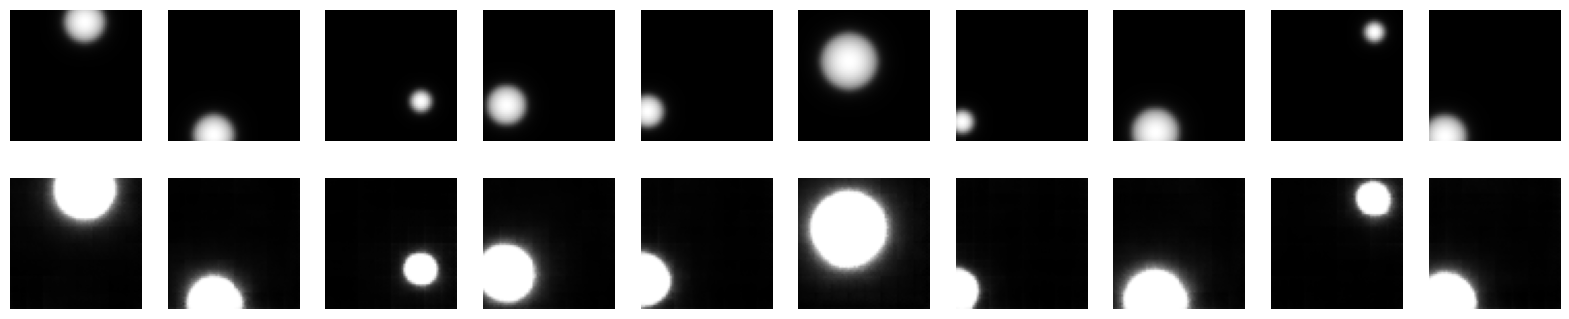

Attention after avg: torch.Size([257, 257])


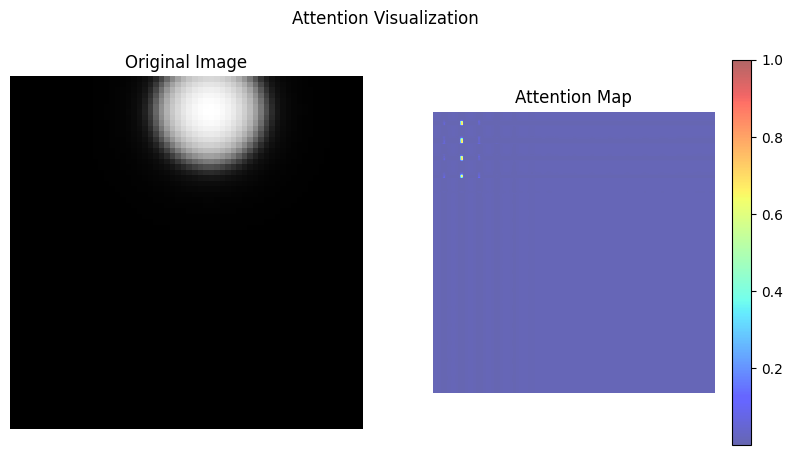

Epoch:16, Loss:19.2705
Epoch:17, Loss:19.2701
Epoch:18, Loss:19.2708
Epoch:19, Loss:19.2703
Epoch:20, Loss:19.2703


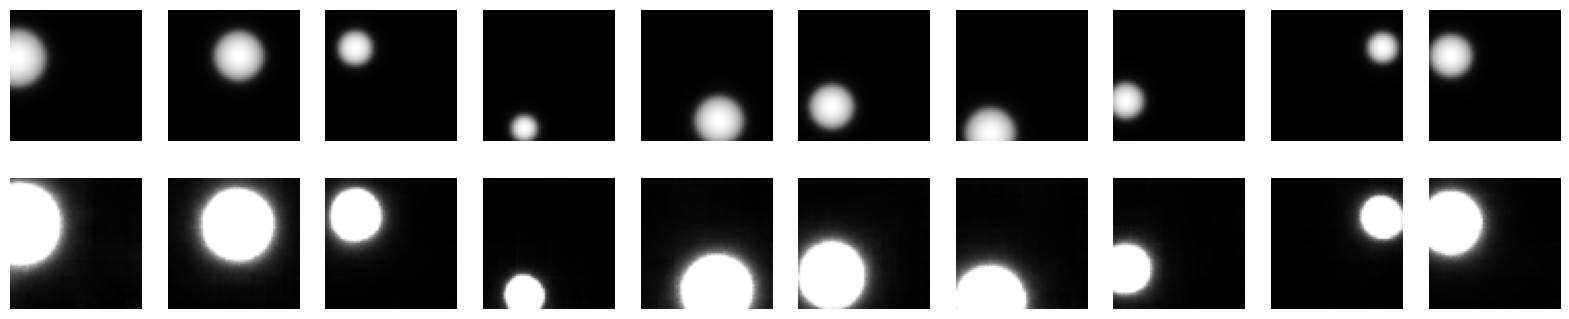

Attention after avg: torch.Size([257, 257])


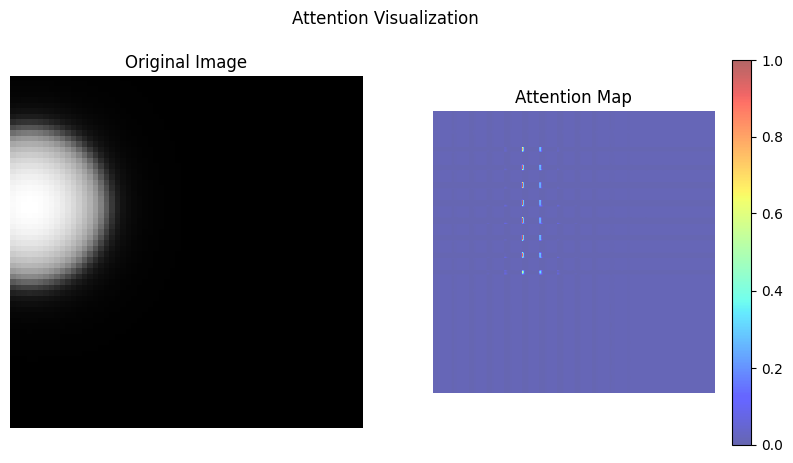

Epoch:21, Loss:19.2691
Epoch:22, Loss:19.2690
Epoch:23, Loss:19.2691
Epoch:24, Loss:19.2692
Epoch:25, Loss:19.2693


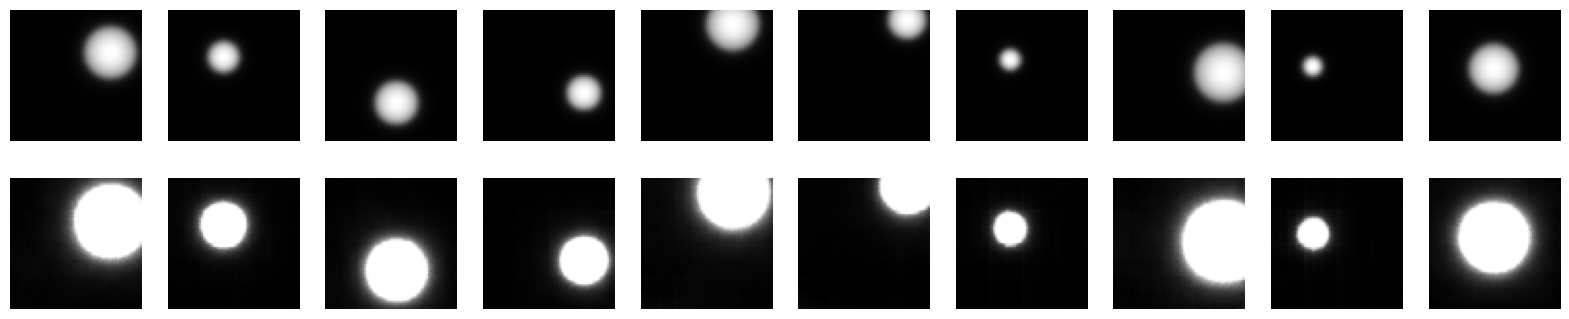

Attention after avg: torch.Size([257, 257])


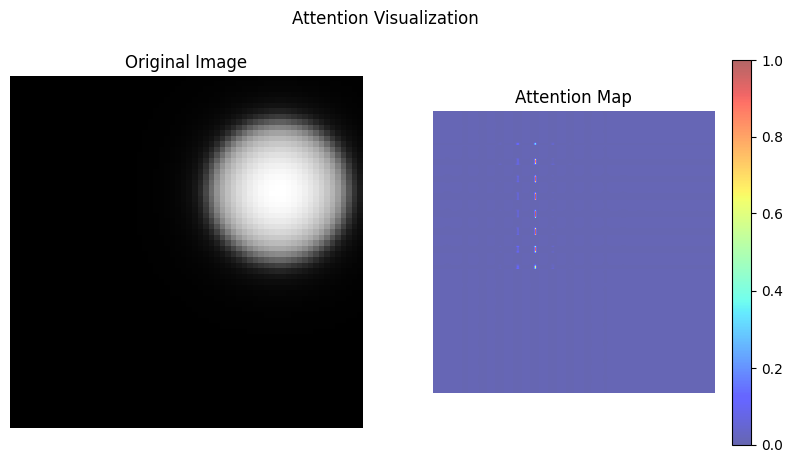

Epoch:26, Loss:19.2691
Epoch:27, Loss:19.2690
Epoch:28, Loss:19.2690
Epoch:29, Loss:19.2691
Epoch:30, Loss:19.2690


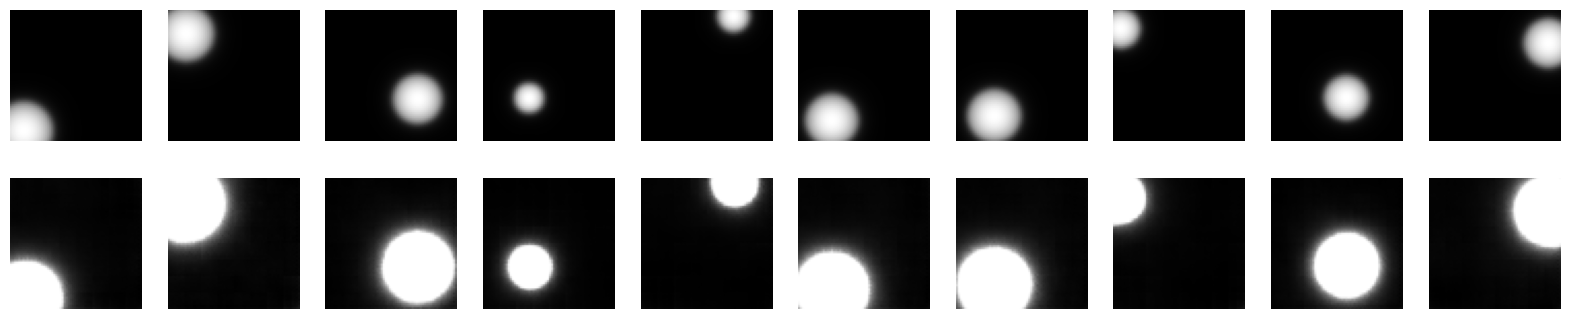

Attention after avg: torch.Size([257, 257])


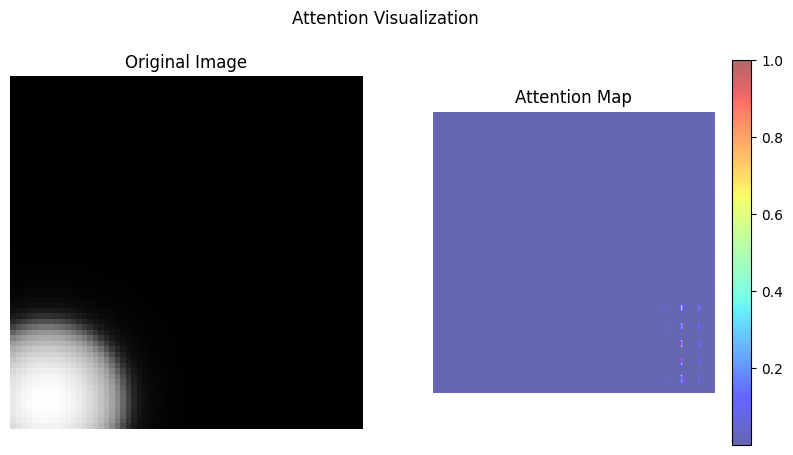

Epoch:31, Loss:19.2685
Epoch:32, Loss:19.2685
Epoch:33, Loss:19.2686
Epoch:34, Loss:19.2686
Epoch:35, Loss:19.2685


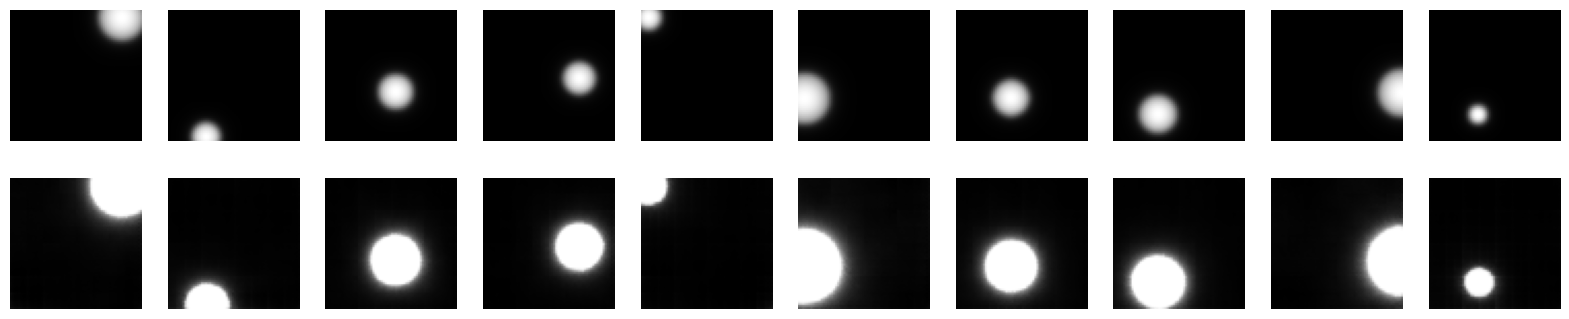

Attention after avg: torch.Size([257, 257])


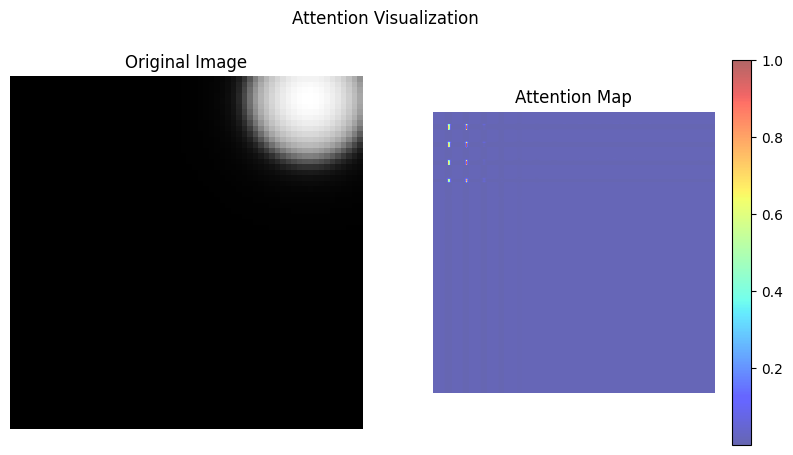

Epoch:36, Loss:19.2685
Epoch:37, Loss:19.2685
Epoch:38, Loss:19.2684
Epoch:39, Loss:19.2685
Epoch:40, Loss:19.2685


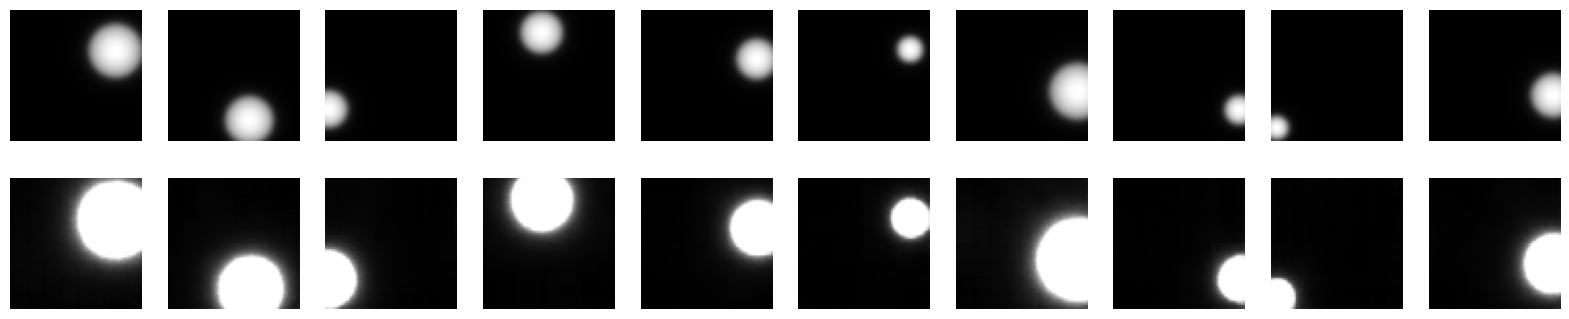

Attention after avg: torch.Size([257, 257])


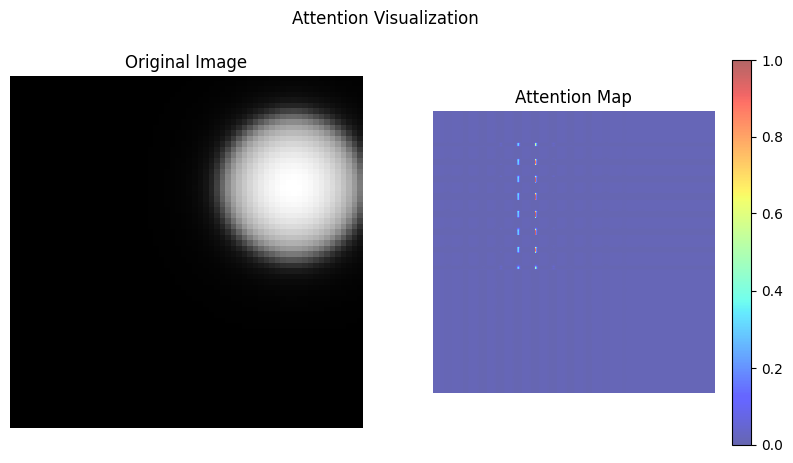

Epoch:41, Loss:19.2683
Epoch:42, Loss:19.2682
Epoch:43, Loss:19.2682
Epoch:44, Loss:19.2683
Epoch:45, Loss:19.2683


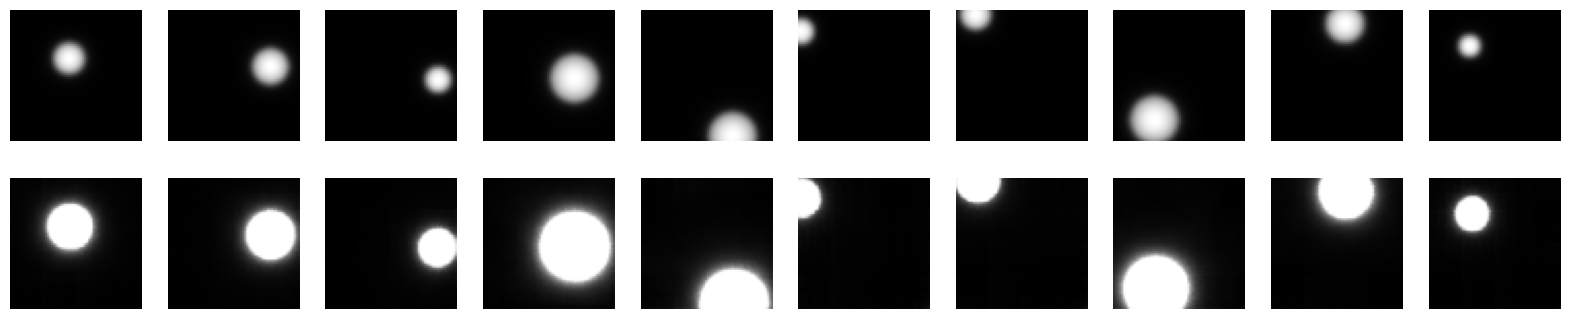

Attention after avg: torch.Size([257, 257])


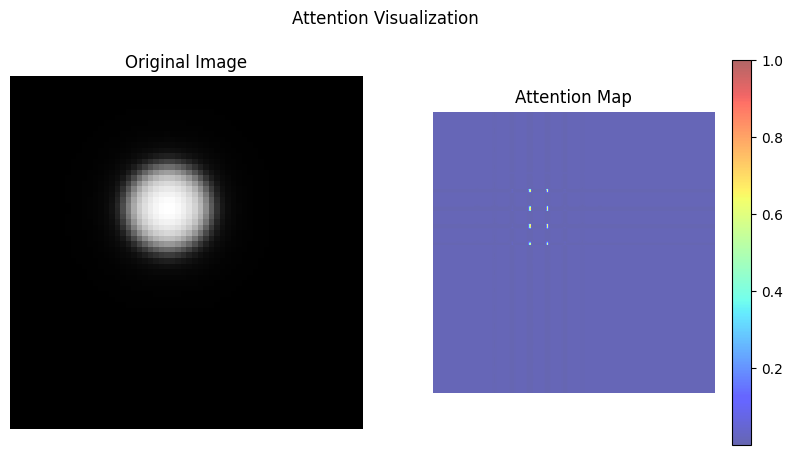

Epoch:46, Loss:19.2682
Epoch:47, Loss:19.2682
Epoch:48, Loss:19.2682
Epoch:49, Loss:19.2682
Epoch:50, Loss:19.2682


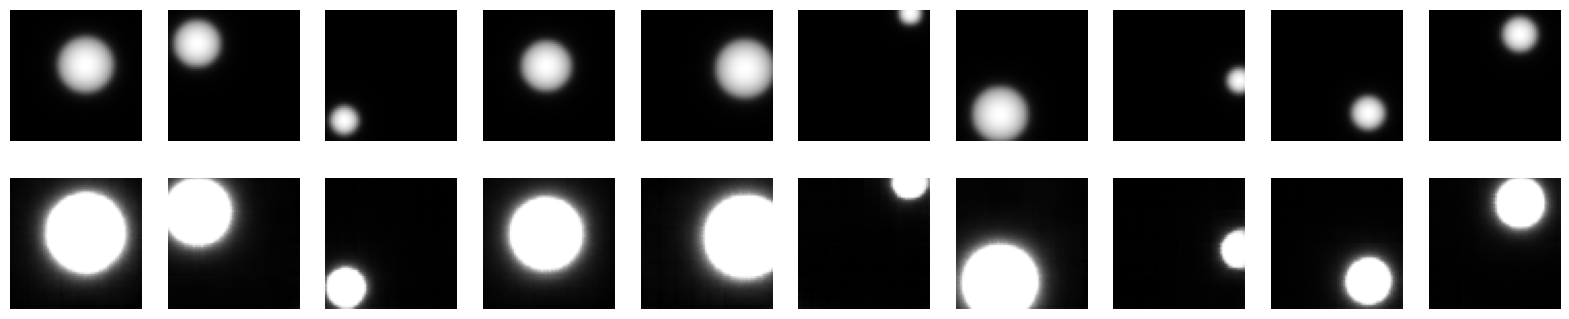

Attention after avg: torch.Size([257, 257])


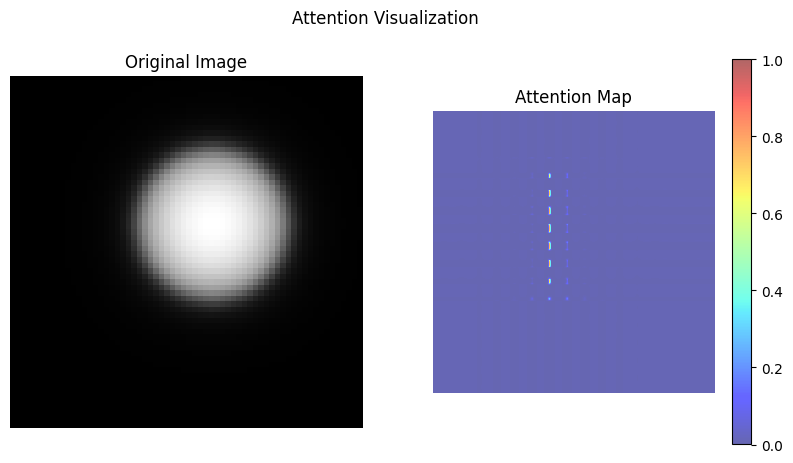

Epoch:51, Loss:19.2681
Epoch:52, Loss:19.2681
Epoch:53, Loss:19.2681
Epoch:54, Loss:19.2681
Epoch:55, Loss:19.2681


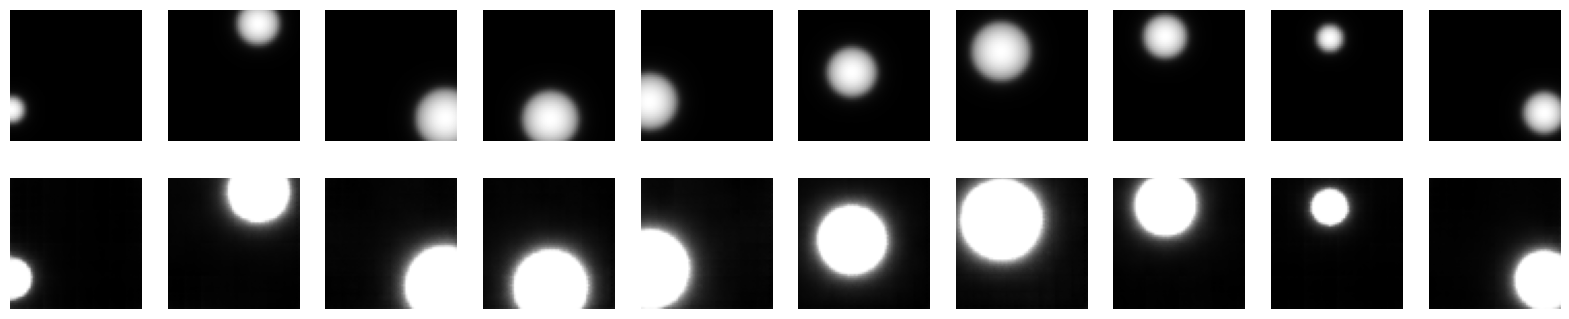

Attention after avg: torch.Size([257, 257])


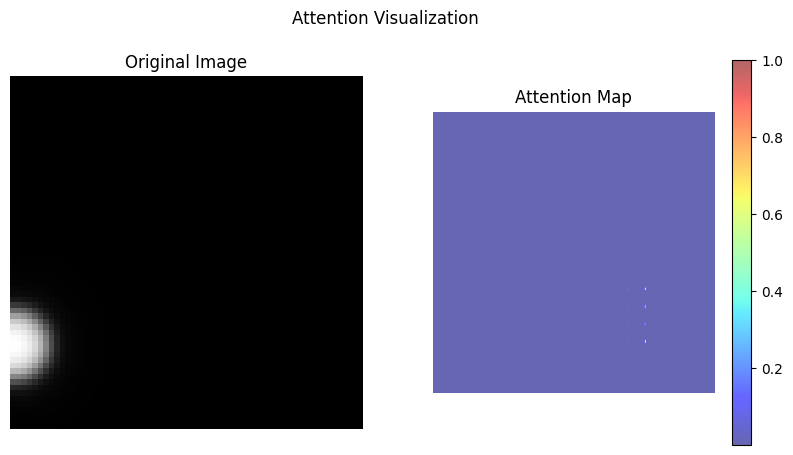

Epoch:56, Loss:19.2681
Epoch:57, Loss:19.2681
Epoch:58, Loss:19.2681
Epoch:59, Loss:19.2681
Epoch:60, Loss:19.2681


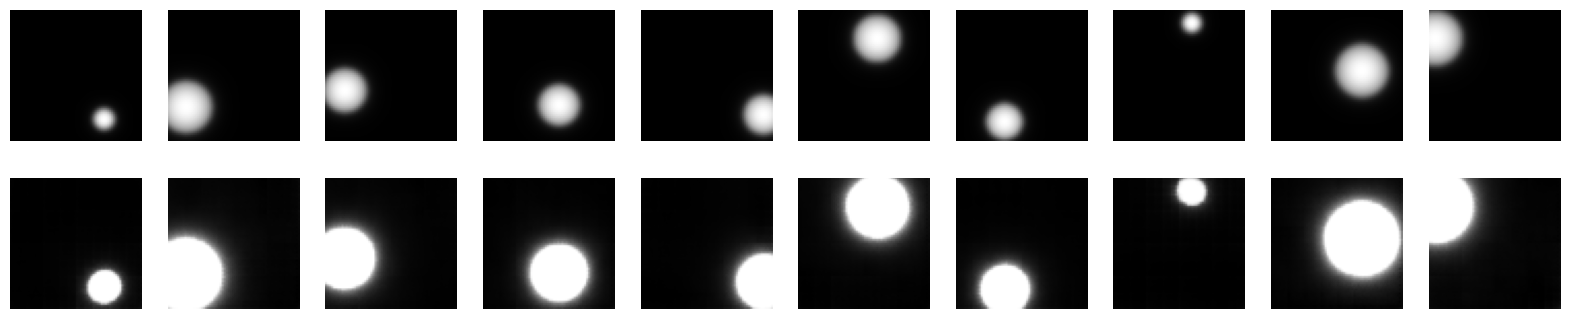

Attention after avg: torch.Size([257, 257])


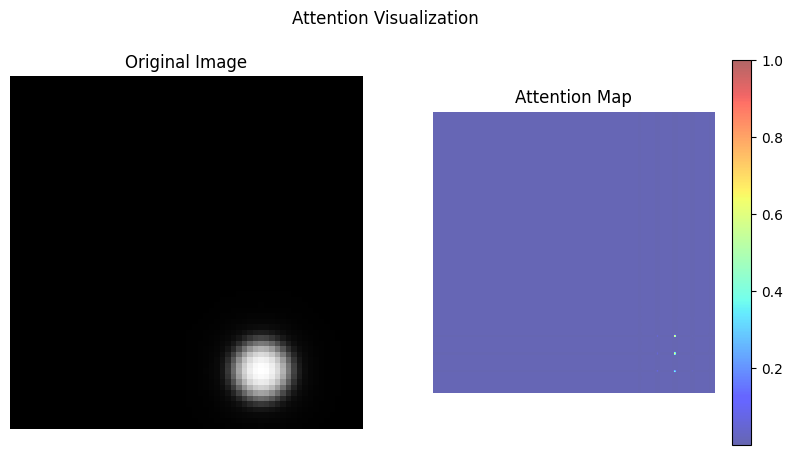

Epoch:61, Loss:19.2680
Epoch:62, Loss:19.2680
Epoch:63, Loss:19.2680
Epoch:64, Loss:19.2680
Epoch:65, Loss:19.2680


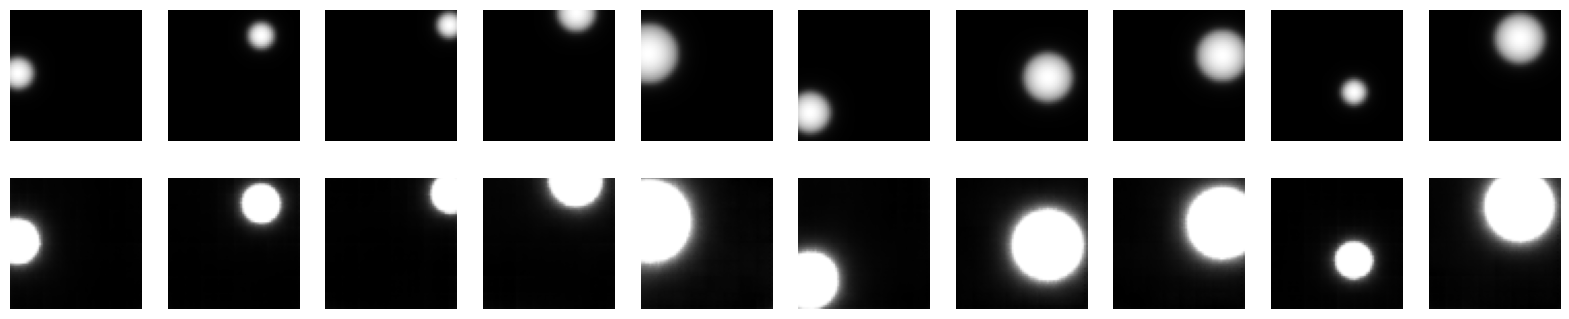

Attention after avg: torch.Size([257, 257])


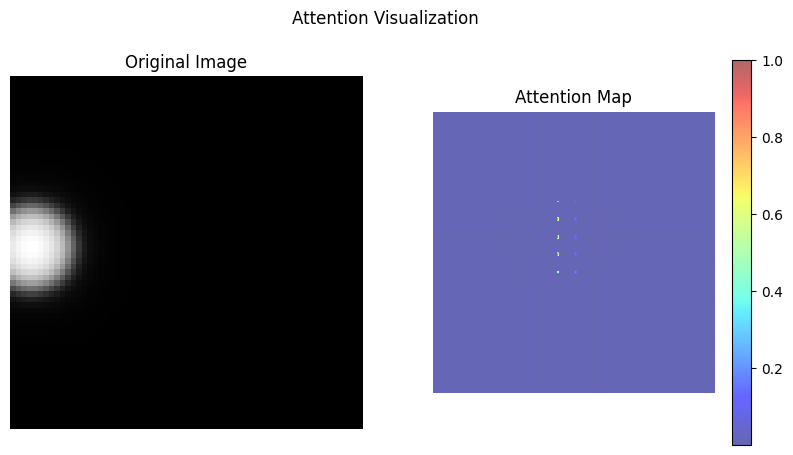

Epoch:66, Loss:19.2680
Epoch:67, Loss:19.2680
Epoch:68, Loss:19.2680
Epoch:69, Loss:19.2680
Epoch:70, Loss:19.2680


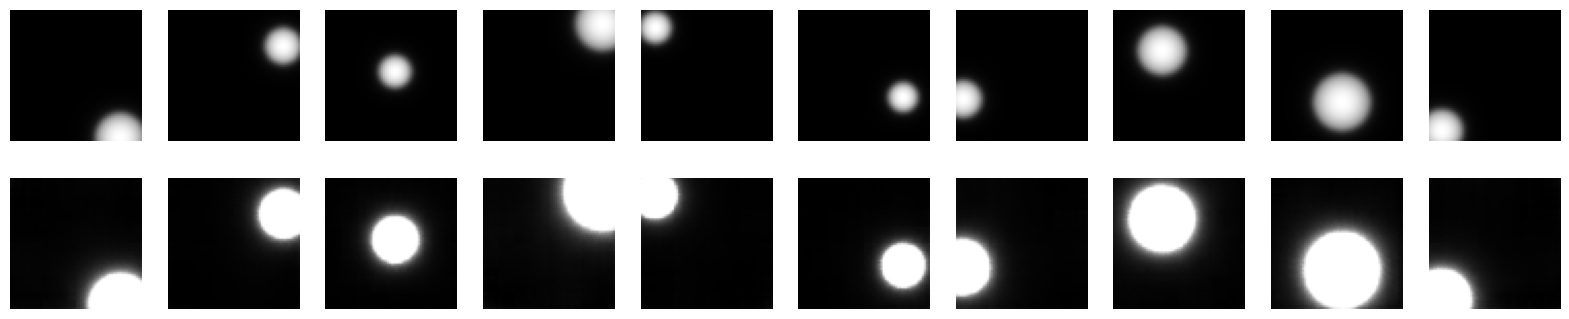

Attention after avg: torch.Size([257, 257])


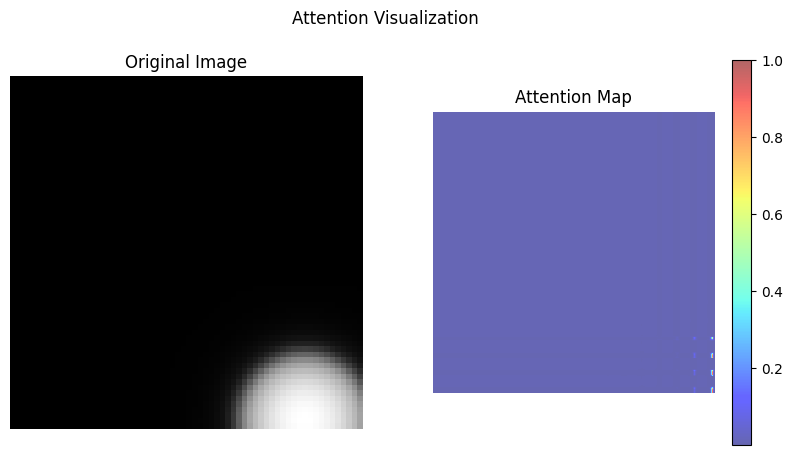

Epoch:71, Loss:19.2680
Epoch:72, Loss:19.2680
Epoch:73, Loss:19.2680
Epoch:74, Loss:19.2680
Epoch:75, Loss:19.2680


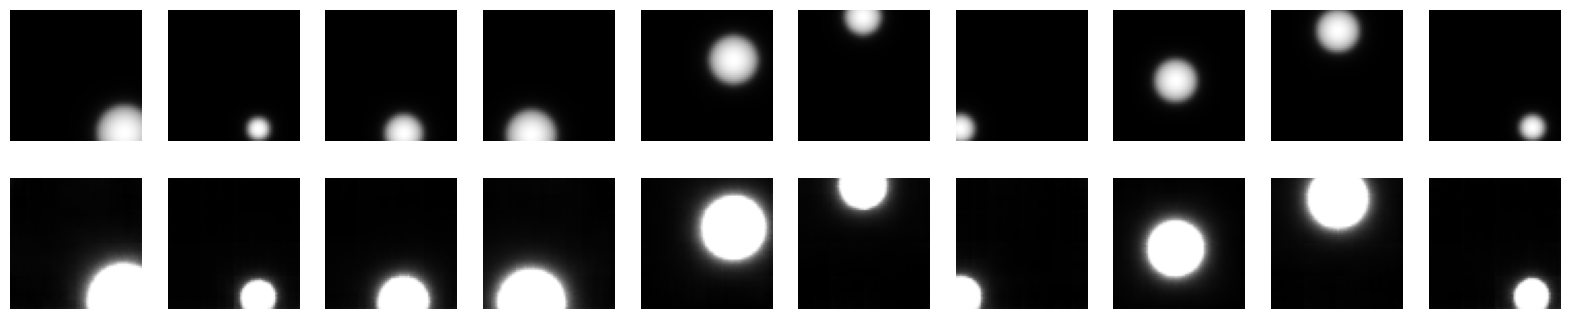

Attention after avg: torch.Size([257, 257])


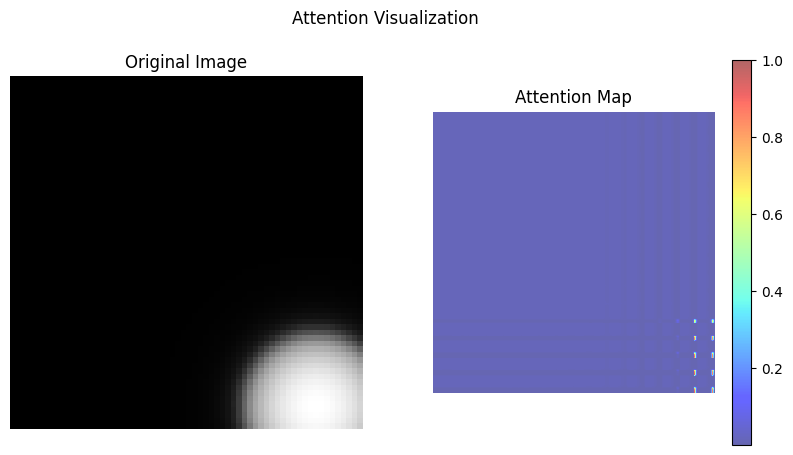

Epoch:76, Loss:19.2680
Epoch:77, Loss:19.2680
Epoch:78, Loss:19.2680
Epoch:79, Loss:19.2680
Epoch:80, Loss:19.2680


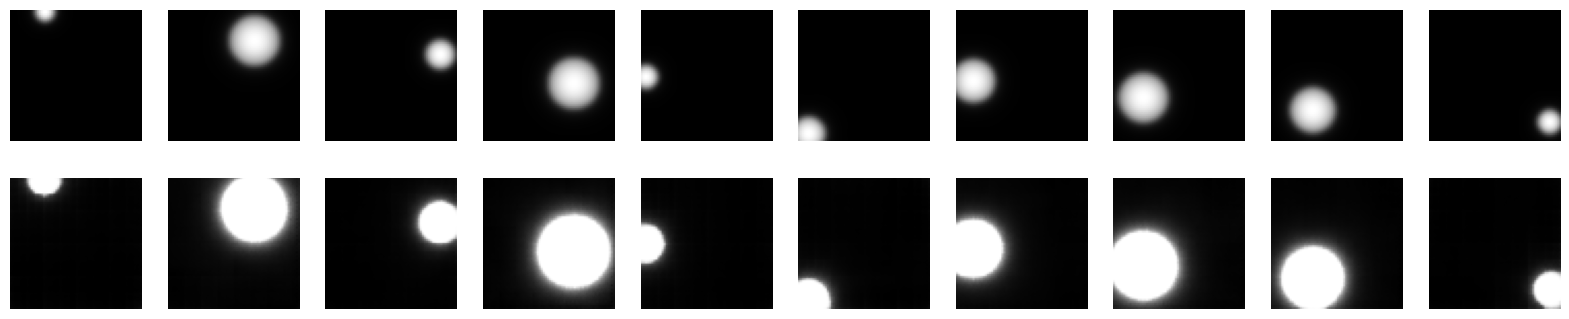

Attention after avg: torch.Size([257, 257])


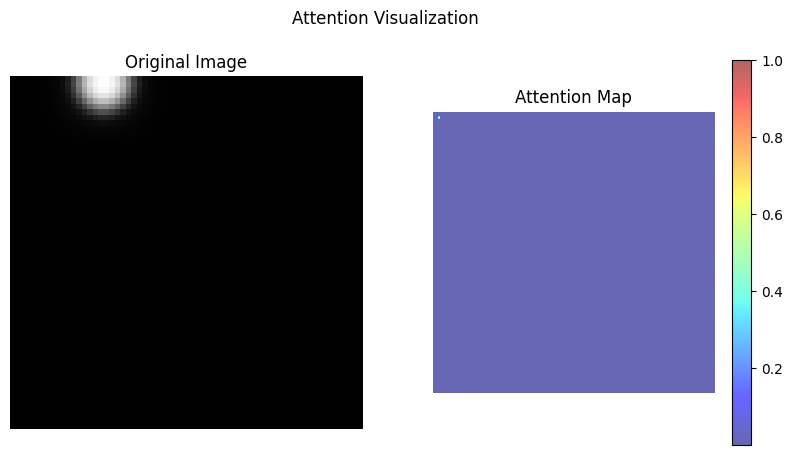

Epoch:81, Loss:19.2680
Epoch:82, Loss:19.2680
Epoch:83, Loss:19.2680
Epoch:84, Loss:19.2680
Epoch:85, Loss:19.2680


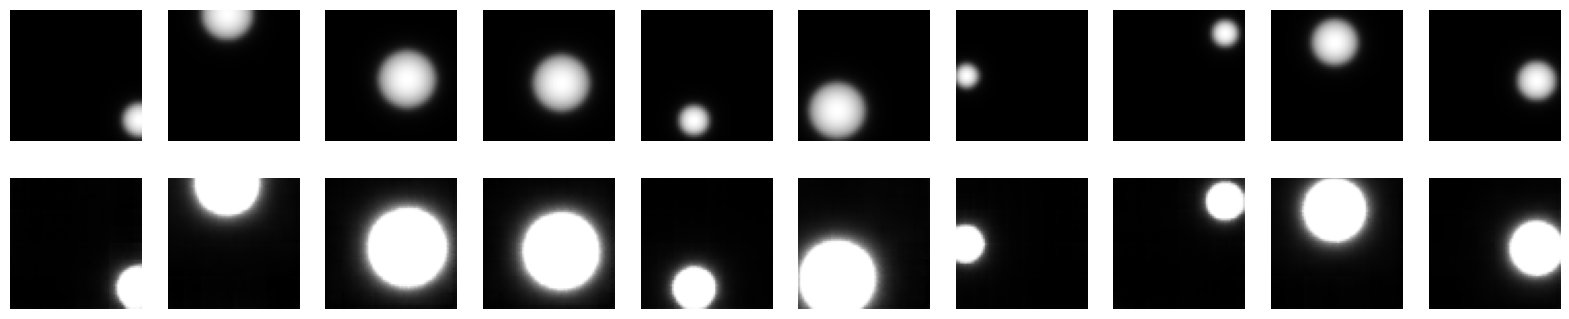

Attention after avg: torch.Size([257, 257])


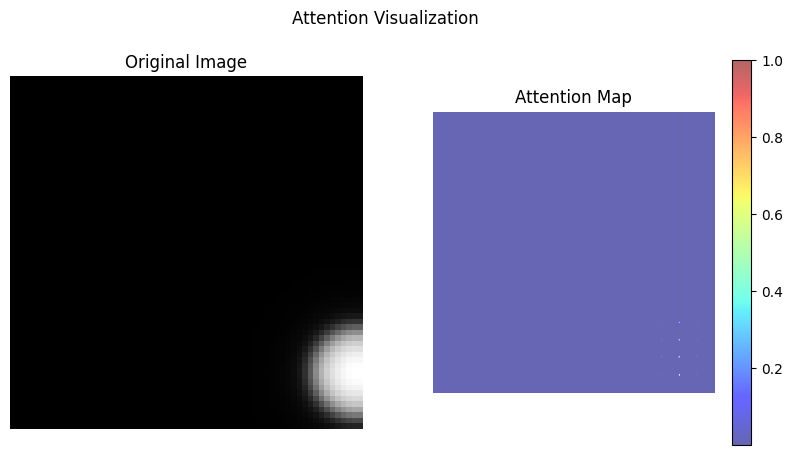

Epoch:86, Loss:19.2680
Epoch:87, Loss:19.2680
Epoch:88, Loss:19.2680
Epoch:89, Loss:19.2680
Epoch:90, Loss:19.2680


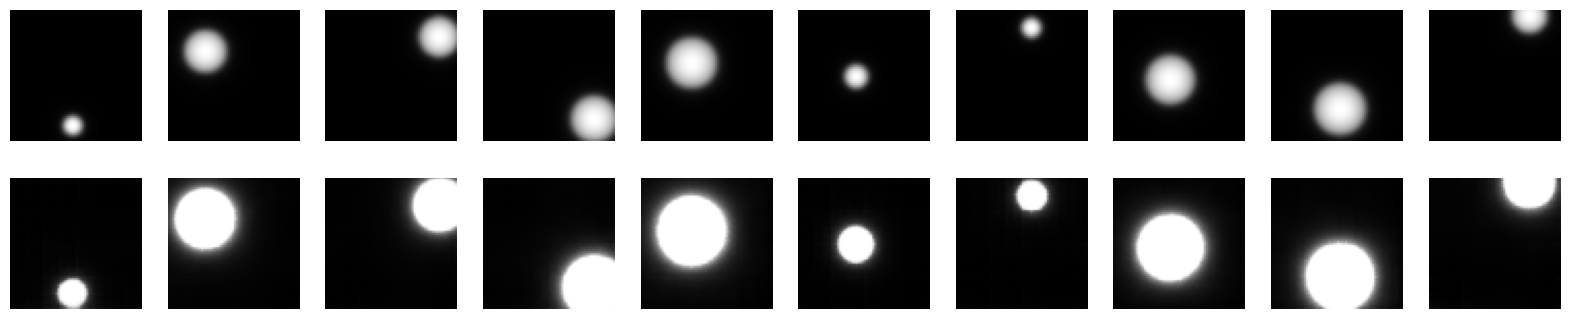

Attention after avg: torch.Size([257, 257])


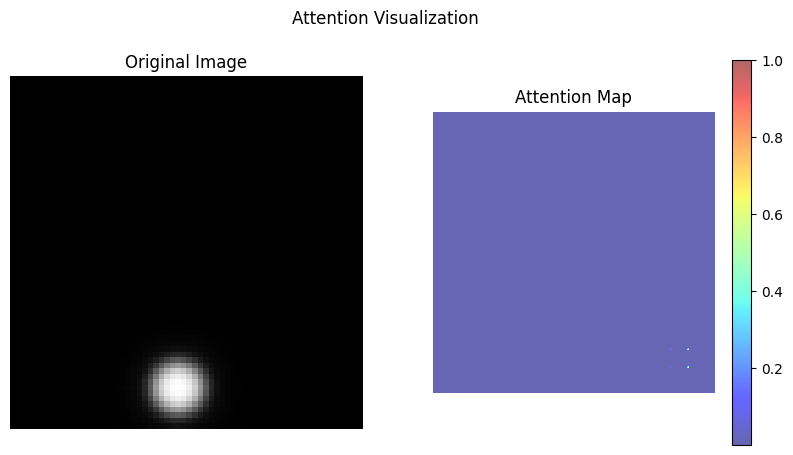

Epoch:91, Loss:19.2680
Epoch:92, Loss:19.2680
Epoch:93, Loss:19.2680
Epoch:94, Loss:19.2680
Epoch:95, Loss:19.2680


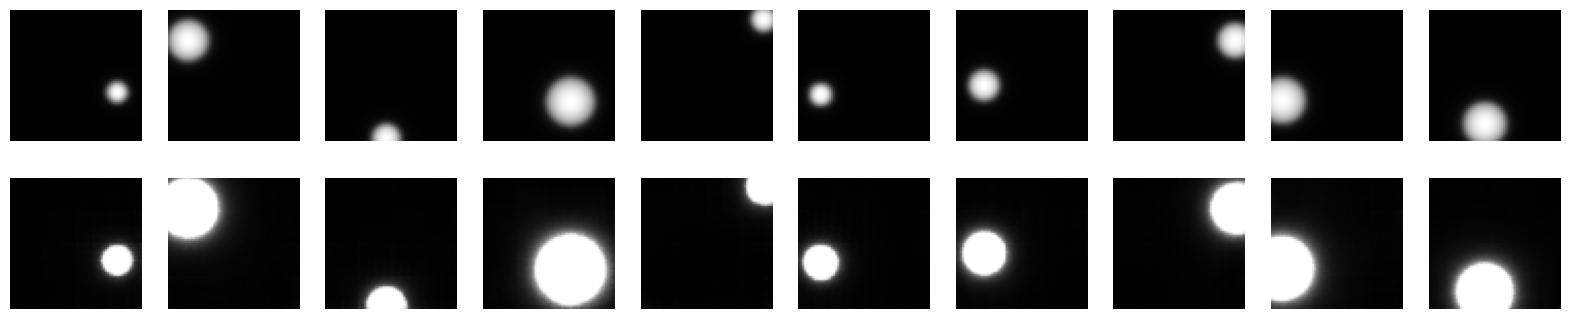

Attention after avg: torch.Size([257, 257])


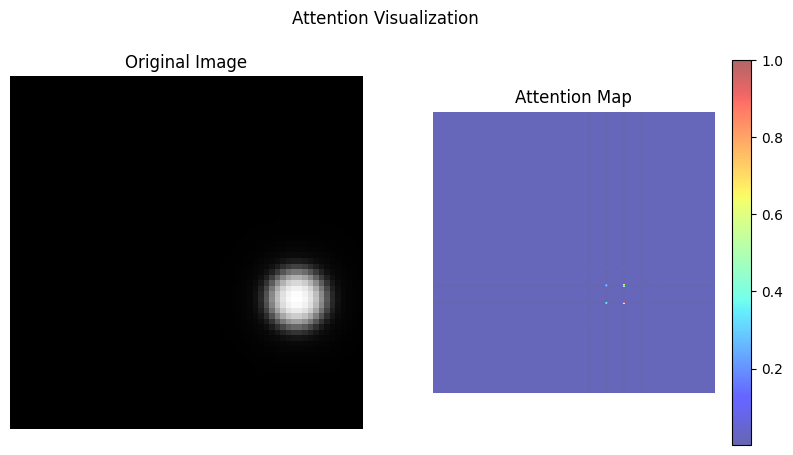

Epoch:96, Loss:19.2680
Epoch:97, Loss:19.2680
Epoch:98, Loss:19.2680
Epoch:99, Loss:19.2680
Epoch:100, Loss:19.2680


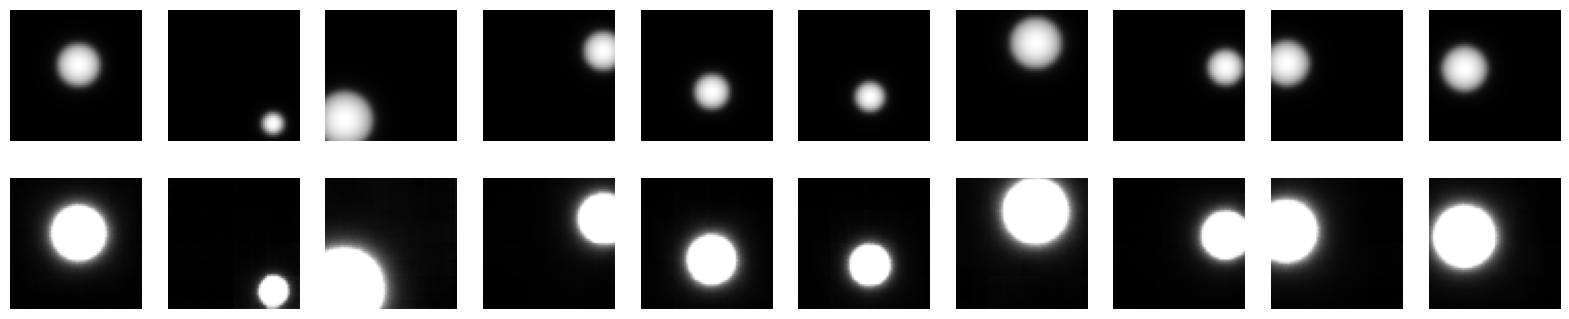

Attention after avg: torch.Size([257, 257])


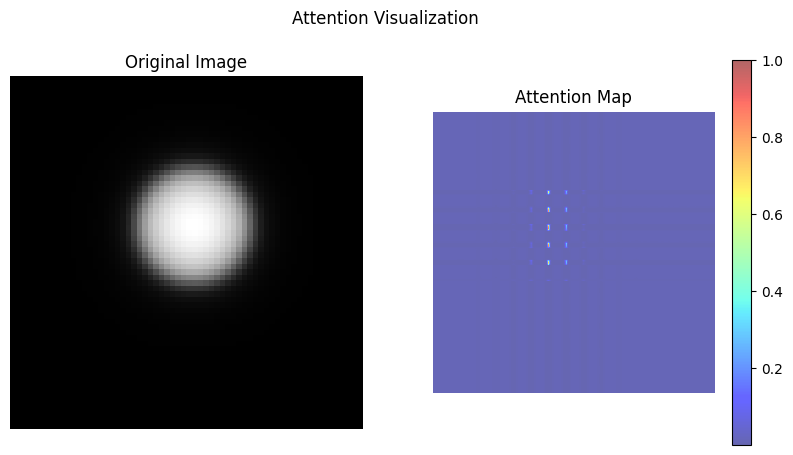

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = ViTAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
num_epochs = 100 
plot_every_n_epochs = 5 



import torch
import numpy as np
import matplotlib.pyplot as plt


# def plot_attention_heatmaps(image, attention, title="Attention Heatmap"):
#     # Average over heads if necessary
#     print(f'attn before avg {attention.shape}')
#     attention_avg =attention.mean(0)  # Reduce over the head dimension, now [num_patches, num_patches]
#     print(attention_avg.shape)
#     # Normalize the attention map for better visualization
#     attention_avg = attention_avg / attention_avg.max()

#     # The attention_avg needs to be in the format (N, C, H, W) where N is batch size and C is channel number
#     # Add batch and channel dimensions
#     # attention_avg = attention_avg.unsqueeze(0).unsqueeze(0)

#     # Ensure the size argument is a tuple of integers representing the spatial dimensions to match the image dimensions
#     # Here, image.shape[1:] should yield (H, W), and ensure 'image' tensor is expected as (C, H, W)
#     # attention_upscaled = torch.nn.functional.interpolate(
#     #     attention_avg,
#     #     size=(image.shape[1], image.shape[2]),  # Match the spatial dimensions of the image
#     #     mode='bilinear',
#     #     align_corners=False
#     # ).squeeze(0).squeeze(0)  # Remove batch and channel dimensions after interpolation

#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')  # Assuming C, H, W and C=3
#     plt.title('Original Image')
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     # plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')  # Show image
#     plt.imshow(attention_avg.cpu().detach().numpy(), cmap='jet', alpha=0.6)  # Overlay attention
#     plt.title('Attention Map')
#     plt.axis('off')
#     plt.colorbar() 
#     plt.suptitle(title)
#     plt.show()
def plot_attention_heatmaps(image, attention, title="Attention Heatmap"):
    # Extract the attention for a single item in the batch, and then average over the heads.
    # Assume we want to plot the attention for the first item in the batch
    # batch_index = 0  # Index for the first image in the batch
    # print(f'weight {attention.shape}')
    single_image_attention = attention# [batch_index, :, :]  # Shape: [num_heads, seq_len, seq_len]
    
    # print(f'Single image attention before avg: {single_image_attention.shape}')
    attention_avg = single_image_attention.mean(0)  # Average across the heads
    print(f'Attention after avg: {attention_avg.shape}')
    # Normalize the attention map for better visualization
    attention_avg = attention_avg / attention_avg.max()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(attention_avg.cpu().detach().numpy(), cmap='jet', alpha=0.6)
    plt.title('Attention Map')
    plt.axis('off')
    plt.colorbar()
    plt.suptitle(title)
    plt.show()


# # Example usage
# model.eval()
# with torch.no_grad():
#     img_batch, _ = next(iter(train_loader))  # Assume this is how you get an image batch
#     output, attn_weights = model(img_batch)  # Make sure your model returns attention weights
#     plot_attention_heatmaps(img_batch[0], attn_weights[0], "Attention Visualization")
# model.train()



def plot_images(input_images, output_images, num_images=10):
    fig, axs = plt.subplots(2, num_images, figsize=(20, 4))
    for i in range(num_images):
        # Original images row
        axs[0, i].imshow(input_images[i].squeeze(), cmap='gray')
        axs[0, i].axis('off')
        # Reconstructed images row
        axs[1, i].imshow(output_images[i].squeeze(), cmap='gray')
        axs[1, i].axis('off')
    
    plt.show()
loss_list=[]
for epoch in range(num_epochs):
    model.train()  # set the model to training mode
    running_loss = 0.0
    for i, (img_batch, _) in enumerate(train_loader):
        # print(img_batch.shape)
        # No need to reshape img as in the commented line since ViT expects 2D images
        # move the batch to the device (CPU/GPU)
        img_batch = img_batch.to(device)
        # Forward pass through the model
        recon , attn_weights = model(img_batch)

        # Calculate the loss
        loss = criterion(recon, img_batch)

        # Backpropagation and optimization
        optimizer.zero_grad()  # Clear existing gradients
        loss.backward()        # Calculate gradients
        optimizer.step()       # Update parameters

        # Add the batch's loss to the running loss
        running_loss += loss.item() * img_batch.size(0)
        
    # Learning rate scheduler step (if exists)
    
    scheduler.step()

    # Calculate the average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)

    loss_list.append(epoch_loss)
    # Print epoch loss
    print(f'Epoch:{epoch+1}, Loss:{epoch_loss:.4f}')
    if (epoch + 1) % plot_every_n_epochs == 0 or epoch==0:
        model.eval()
        with torch.no_grad():
            img_sample, _ = next(iter(train_loader))
            img_sample = img_sample.to(device)
            recon_sample, attn_weights = model(img_sample)
            # print(f'final attn {attn_weights.shape}')
            plot_images(img_sample[:10].cpu(), recon_sample[:10].cpu(), 10)
            plot_attention_heatmaps(img_sample[0].cpu(), attn_weights[:,0,:,:].cpu(), "Attention Visualization")
        model.train()



<function matplotlib.pyplot.show(close=None, block=None)>

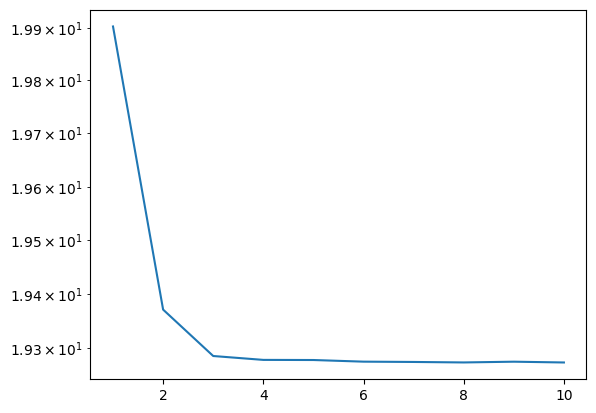

In [36]:
plt.plot(np.arange(1,epoch+2),loss_list)
plt.yscale('log')
plt.show

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = ViTAutoencoder().to(device)  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
num_epochs = 200  
plot_every_n_epochs = 10 



import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_attention_heatmaps(image, attention, title="Attention Heatmap"):
    # Average over heads if necessary
    attention_avg = attention.mean(0)  # Reduce over the head dimension, now [num_patches, num_patches]

    # Normalize the attention map for better visualization
    attention_avg = attention_avg / attention_avg.max()

    # The attention_avg needs to be in the format (N, C, H, W) where N is batch size and C is channel number
    # Add batch and channel dimensions
    attention_avg = attention_avg.unsqueeze(0).unsqueeze(0)

    # Ensure the size argument is a tuple of integers representing the spatial dimensions to match the image dimensions
    # Here, image.shape[1:] should yield (H, W), and ensure 'image' tensor is expected as (C, H, W)
    # attention_upscaled = torch.nn.functional.interpolate(
    #     attention_avg,
    #     size=(image.shape[1], image.shape[2]),  # Match the spatial dimensions of the image
    #     mode='bilinear',
    #     align_corners=False
    # ).squeeze(0).squeeze(0)  # Remove batch and channel dimensions after interpolation

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')  # Assuming C, H, W and C=3
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')  # Show image
    plt.imshow(attention_avg.cpu().detach().numpy(), cmap='jet', alpha=0.6)  # Overlay attention
    plt.title('Attention Map')
    plt.axis('off')
    plt.colorbar() 
    plt.suptitle(title)
    plt.show()

def plot_class_token_attention(original_image, attention_weights, title="Class Token Attention"):
    # Extract the attention weights for the class token, which we assume to be the first in the sequence
    class_token_attention = attention_weights[:, 0, 1:]  # All batch, class token, all patches except class token

    # Average the attention across the batch dimension if needed
    class_token_attention_avg = class_token_attention.mean(0)

    # Normalize the attention weights for visualization
    class_token_attention_avg /= class_token_attention_avg.max()

    # Reshape into a square matrix
    num_patches_side = int(np.sqrt(class_token_attention_avg.shape[0]))
    class_token_attention_sq = class_token_attention_avg.reshape((num_patches_side, num_patches_side)).cpu().numpy()

    # Upscale the attention matrix to the size of the original image
    attention_map_upscaled = F.interpolate(
        torch.tensor(class_token_attention_sq).unsqueeze(0).unsqueeze(0),
        size=original_image.shape[-2:],
        mode='bilinear',
        align_corners=False
    ).squeeze(0).squeeze(0).numpy()

    # Plot the original image and the attention heatmap
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.imshow(attention_map_upscaled, cmap='hot', alpha=0.6)
    plt.title('Class Token Attention Map')
    plt.axis('off')
    plt.show()

# # Example usage
# model.eval()
# with torch.no_grad():
#     img_batch, _ = next(iter(train_loader))  # Assume this is how you get an image batch
#     output, attn_weights = model(img_batch)  # Make sure your model returns attention weights
#     plot_attention_heatmaps(img_batch[0], attn_weights[0], "Attention Visualization")
# model.train()



def plot_images(input_images, output_images, num_images=10):
    fig, axs = plt.subplots(2, num_images, figsize=(20, 4))
    for i in range(num_images):
        # Original images row
        axs[0, i].imshow(input_images[i].squeeze(), cmap='gray')
        axs[0, i].axis('off')
        # Reconstructed images row
        axs[1, i].imshow(output_images[i].squeeze(), cmap='gray')
        axs[1, i].axis('off')
    
    plt.show()

for epoch in range(num_epochs):
    model.train()  # set the model to training mode
    running_loss = 0.0
    for i, (img_batch, _) in enumerate(train_loader):
        img_batch = img_batch.to(device)  # Move the batch to the GPU

        # Forward pass through the model
        recon, attn_weights = model(img_batch)

        # Calculate the loss
        loss = criterion(recon, img_batch)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img_batch.size(0)
        
    scheduler.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch:{epoch+1}, Loss:{epoch_loss:.4f}')
    
    if (epoch + 1) % plot_every_n_epochs == 0 or epoch == 0:
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            img_sample, _ = next(iter(train_loader))
            img_sample = img_sample.to(device)
            recon_sample, attn_weights = model(img_sample)
            # Select the first image and attention weights from the batch for visualization
            plot_class_token_attention(img_sample[0].cpu(), attn_weights.cpu(), f"Epoch {epoch+1} Class Token Attention")
        model.train()  # Set the model back to training mode


Using device: cuda
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 257])
attention weight torch.Size([8, 32, 257, 

RuntimeError: shape '[16, 16]' is invalid for input of size 65792